# Create Project

In [41]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

## Functions

In [15]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [20]:
# get coefficients function
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [29]:
# plot coefficients functions
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    fig= ax.get_figure()
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
#sns.plt.show()
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

In [34]:
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

##  Load the Data

In [2]:
#create pandas dataframe
filename='Data/sales_predictions - sales_predictions (1).csv'
df = pd.read_csv(filename)

In [3]:
## Display the first (5) rows of the dataframe
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [4]:
## Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent \
{df.shape[1]-1} features and 1 target variable.')


There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


In [7]:
# Fix the fat content row done in all projects
# fix the inconsistencies  in the "item_Fat_Content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Explore the data

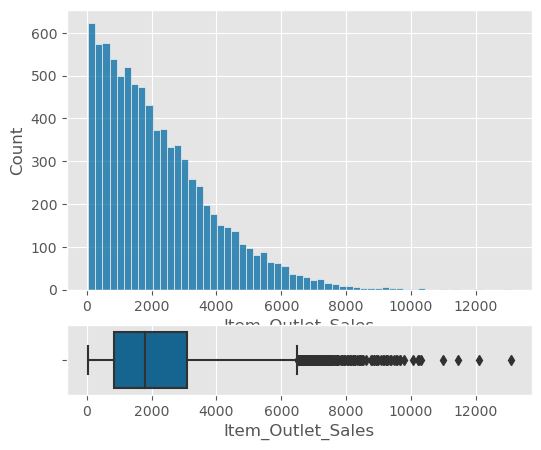

In [6]:
#create EDA of the target
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

## Preprocessing

In [8]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")


Python 3.9.15
sklearn version: 1.1.3


In [61]:
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = []

#Set target
target = 'Item_Outlet_Sales'
X = df.drop(columns = target)
y = df[target]

#y = df[target].copy()
#X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
8269           FDI60       7.2200          Regular           0.0641   
7604           DRD25       6.1350          Low Fat           0.0793   
2762           NCP18      12.1500          Low Fat           0.0286   

         Item_Type  Item_MRP Outlet_Identifier  Outlet_Establishment_Year  \
8269  Baking Goods   61.2510            OUT010                       1998   
7604   Soft Drinks  111.2860            OUT018                       2009   
2762     Household  151.0708            OUT035                       2004   

     Outlet_Size Outlet_Location_Type        Outlet_Type  
8269         NaN               Tier 3      Grocery Store  
7604      Medium               Tier 3  Supermarket Type2  
2762       Small               Tier 2  Supermarket Type1

In [63]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [64]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CD0E818280>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CD0E8181C0>)])

In [65]:
## make the preprocessing column transformer 
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
8269       7.2200           0.0641   61.2510                 1,998.0000   
7604       6.1350           0.0793  111.2860                 2,009.0000   
2762      12.1500           0.0286  151.0708                 2,004.0000   
6464       5.9450           0.0930  127.8652                 2,004.0000   
4707      18.2000           0.0663  247.2092                 2,004.0000   
2565       8.2350           0.0145  184.4950                 2,007.0000   
1412       4.6100           0.1233  172.5396                 2,007.0000   
184       12.8226           0.0494  226.8062                 1,985.0000   
6556      12.8226           0.0788  103.0016                 1,985.0000   
3392       7.0900           0.0072   47.6034                 1,997.0000   
6709      12.8226           0.0301  154.3656                 1,985.0000   
3186       7.6300           0.1349   46.9402                 1,999.0000   
905       17.8500           0.0658  149.1050                 1,997.0000   
7011       5.3650           0.1408  173.5764                 2,009.0000   
5369       5.8800           0.0000  154.2998                 1,997.0000   
4524      19.6000           0.1283  167.2816                 2,002.0000   
7713      12.8226           0.1666  157.6604                 1,985.0000   
4611      12.8226           0.0416  104.4332                 1,985.0000   
94         9.8000           0.0244  114.5492                 2,004.0000   
3058      12.8226           0.0670   39.2796                 1,985.0000   
1963      12.3500           0.1643  119.8124                 2,002.0000   
3432       5.4250           0.1916   87.0514                 1,998.0000   
8478       6.1950           0.0720  121.3098                 2,004.0000   
6465      18.2500           0.1718  154.6630                 2,007.0000   
5366      10.1950           0.2115  110.9886                 1,998.0000   
486       16.6000           0.1032  117.8466                 2,002.0000   
5796      12.5000           0.0626  196.9426                 2,009.0000   
2982      12.8226           0.0296   40.9822                 1,985.0000   
3061      19.2500           0.0347  140.1496                 2,004.0000   
6105      12.8226           0.0440  148.2734                 1,985.0000   
713       10.3950           0.0313  160.0604                 1,999.0000   
1299      19.6000           0.0396  166.1526                 1,997.0000   
3302      16.2000           0.0334   73.9696                 2,002.0000   
6812      15.6000           0.0667  185.8924                 1,997.0000   
3581      15.6000           0.0811  112.3544                 1,997.0000   
730       12.3500           0.0725   48.5692                 2,002.0000   
2293      10.8000           0.0290  238.6222                 2,002.0000   
2602       9.1700           0.1031  141.7470                 1,999.0000   
2538       7.2350           0.0581  115.8834                 2,004.0000   
8005      12.6500           0.0760  192.3846                 1,987.0000   
5828      12.3500           0.1587  157.2946                 1,999.0000   
980       10.1950           0.1074  147.6076                 2,004.0000   
601       20.8500           0.1213  193.9452                 1,997.0000   
3464       9.3950           0.1037  233.6932                 1,987.0000   
5700       8.3500           0.1269   74.4354                 1,997.0000   
5327       7.9750           0.0146   82.3250                 2,004.0000   
7365      14.6000           0.0430  196.9084                 1,998.0000   
4237      16.7500           0.0086   73.2038                 2,004.0000   
174       17.7000           0.2919  115.1834                 1,998.0000   
2386      16.0000           0.1072  181.9634                 2,009.0000   
4333      15.8500           0.1365   96.3094                 1,997.0000   
1124      13.8000           0.0147   90.9172                 2,004.0000   
6995       9.5000           0.0

# Models

## Baseline linear regression

In [66]:
# first lin reg
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [73]:
#look at goefficients
coeffs = get_coefficients(lin_reg)
coeffs.head()

Item_Weight                              -2.4143
Item_Visibility                        -794.9584
Item_MRP                                -11.0798
Outlet_Establishment_Year    -1,760,336,998.9621
Item_Identifier_DRA12       218,885,767,102.1779
dtype: float64

In [68]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [74]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

Outlet_Location_Type_Tier 3   -23,257,681,116,380.1641
Outlet_Location_Type_Tier 1   -21,419,618,372,825.2656
Item_Identifier_FDH09          -6,319,555,156,111.4072
Item_Identifier_FDJ45          -6,319,555,156,065.3770
Item_Identifier_FDK45          -6,319,555,154,136.5098
Item_Identifier_FDF33          -6,319,555,153,621.1895
Item_Identifier_FDH21          -6,319,555,152,827.8652
Item_Identifier_FDI57          -6,319,555,150,650.1846
Item_Type_Seafood               5,969,477,146,125.3027
Outlet_Identifier_OUT013        6,611,813,700,238.7676
Outlet_Type_Grocery Store       8,393,005,830,527.7949
Outlet_Size_High                9,954,342,450,357.1074
Outlet_Identifier_OUT046       11,892,771,049,710.6484
Outlet_Size_Medium             14,536,567,023,831.8809
intercept                      15,302,931,823,265.5215
dtype: float64

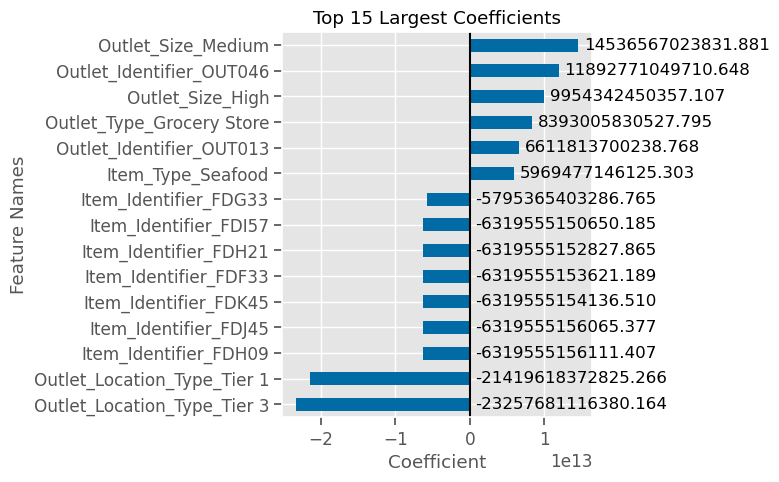

In [71]:
#plot coeffs with function
lr_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
fig.savefig('Images/Top 15 with Linear Regression')


### Three most impactful coefficients:¶


- Outlet size: the size of the outlet affect grocery sales
- Outlet identifier- this is a not useful index
- Outlet type: similar to size but differences between a grocery store and an outlet

### address coefficients with multicollinearity

## Drop Coefficients without Outlet Identifier

In [72]:
## Get a list of all of the outlet identifier columns
outid_feats = [c for c in X_train_df.columns if c.startswith('Outlet_Identifier')]
len(outid_feats)

10

In [43]:
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = ["Outlet_Identifier", "Item_Identifier"]

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [44]:
# run prerpocessor
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)

In [45]:
#evaluate without  outlet identifier
lin_reg2= LinearRegression(fit_intercept=False)
lin_reg2.fit(X_train_df,y_train)
evaluate_regression(lin_reg2, X_train_df, y_train, 
                    X_test_df, y_test)

In [46]:
#visualize coefficients (manually)
coeffs2 = pd.Series(lin_reg2.coef_, index=feature_names,
                        name='Coefficients')
coeffs2.loc['intercept'] = lin_reg.intercept_
coeffs2.head()

Item_Weight                       1.0679
Item_Visibility                -276.6116
Item_MRP                         15.6019
Outlet_Establishment_Year        36.3821
Item_Fat_Content_Low Fat    -25,976.1199
Name: Coefficients, dtype: float64

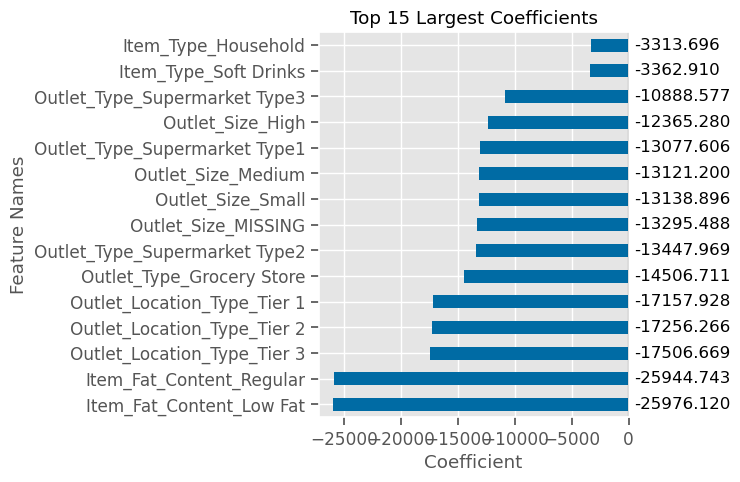

In [59]:
lr_plot = plot_coeffs(coeffs2,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
fig.savefig('Images/Top 15 with Linear Regression2')

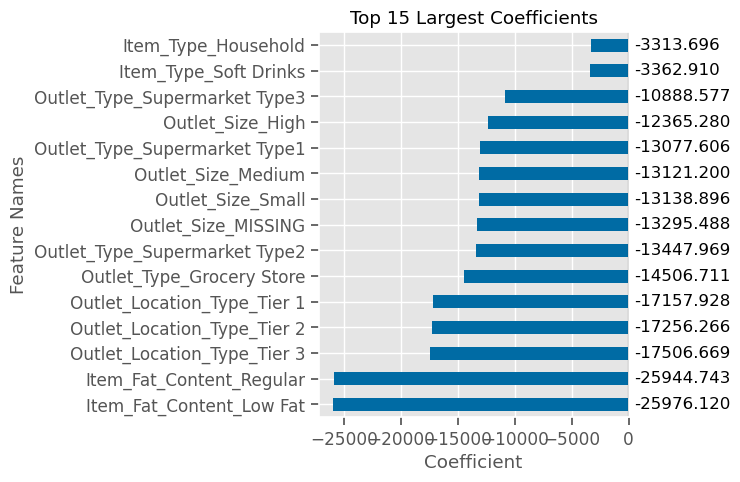

In [47]:
lr_plot = plot_coeffs(coeffs2,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
fig.savefig('Images/Top 15 with Linear Regression_no Outlet Indentifier')

### Five most important features in linear regression without outlet identifier type
- Item Type Low Fat: Fat content affect sales
- Item Type Regular Fat: Fat content affect sales
- Outlet Location 3:  where the supermarket is affects sales
- Outlet Location 2:  where the supermarket is affects sales
- Outlet Location 1:  where the supermarket is affects sales

## Random Forest Model

In [48]:
# instantiate the model, fit and evaluate
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [49]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                       0.0536
Item_Visibility                   0.0993
Item_MRP                          0.4466
Outlet_Establishment_Year         0.0381
Item_Fat_Content_Low Fat          0.0047
Item_Fat_Content_Regular          0.0049
Item_Type_Baking Goods            0.0046
Item_Type_Breads                  0.0030
Item_Type_Breakfast               0.0025
Item_Type_Canned                  0.0042
Item_Type_Dairy                   0.0056
Item_Type_Frozen Foods            0.0058
Item_Type_Fruits and Vegetables   0.0084
Item_Type_Hard Drinks             0.0029
Item_Type_Health and Hygiene      0.0044
Item_Type_Household               0.0062
Item_Type_Meat                    0.0037
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0014
Item_Type_Snack Foods             0.0080
Item_Type_Soft Drinks             0.0042
Item_Type_Starchy Foods           0.0029
Outlet_Size_High                  0.0022
Outlet_Size_MISSING               0.0051
Outlet_Size_Medi

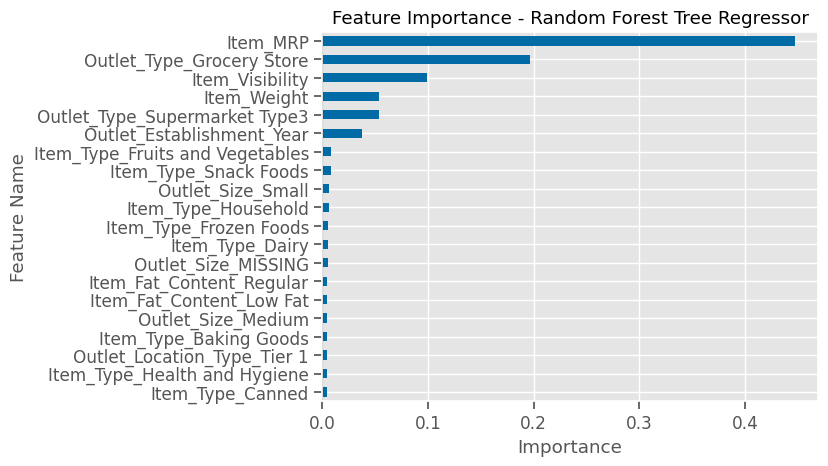

In [52]:
# Create plot
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Random Forest Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');
fig.savefig('Images/Feature Importance with Random Forest')

### Five most important features for random forest
- 1. Item MRP: suggest retail prices affects the sale
- 2. Outlet Type Grocery  affects the sales
- 3. Item visibility affects the sales
- 4. Item weight affects the sales
- 5. Outlet Type Supermarket affects  the sales

### Adding the sixth
- 6. Outlet Year affects the sales: this was significant in earlier projects


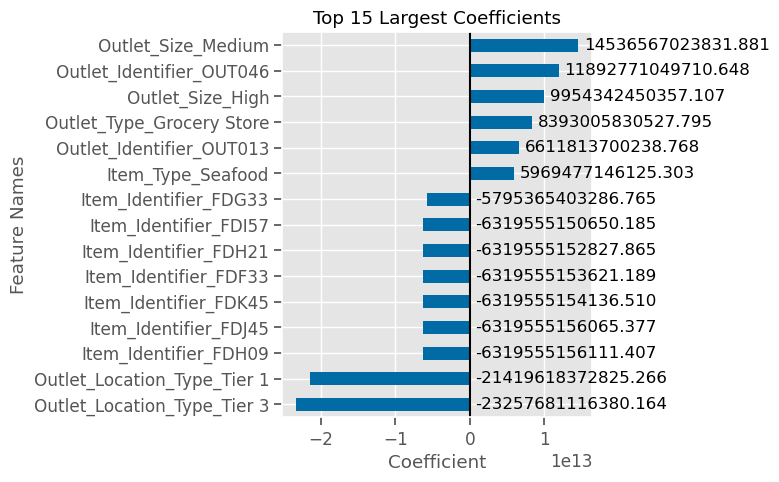

In [50]:
#save image
rf_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=rf_plot.get_figure()
fig.savefig('Images/Top 15 with Random Forest')

# Export Data Using Joblib

In [57]:
# evaluate linear regression
evaluate_regression(lin_reg2,X_train_df,y_train, X_test_df, y_test)

In [58]:
#evaluate random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

In [78]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [79]:
#create folder
folder = "Models/"
os.makedirs(folder, exist_ok=True)

In [80]:
fname = folder+'grocery_sales'
joblib.dump(export, fname)

['Models/grocery_sales']

In [81]:
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])